In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
csv_modelA = './save/icbhi_beats_ce_seed4_best/patient_evaluation.csv'
csv_modelB = './save/icbhi_beats_pafa_seed4_best_50_0.0005/patient_evaluation.csv'

In [75]:
dfA = pd.read_csv(csv_modelA)
dfB = pd.read_csv(csv_modelB)

In [76]:
print("=== Model A Data Preview ===")
print(dfA.head(), "\n")
print("=== Model B Data Preview ===")
print(dfB.head())

=== Model A Data Preview ===
   patient id  number of samples  accuracy    spesific  sensitive      score
0           0               23.0  0.956522   95.652174   0.000000  47.826087
1           1               13.0  1.000000  100.000000   0.000000  50.000000
2           2               55.0  0.654545   72.727273  36.363636  54.545455
3           3               61.0  0.655738   67.391304  60.000000  63.695652
4           4               50.0  0.920000   92.000000   0.000000  46.000000 

=== Model B Data Preview ===
   patient id  number of samples  accuracy    spesific  sensitive      score
0           0               23.0  1.000000  100.000000   0.000000  50.000000
1           1               13.0  0.769231   76.923077   0.000000  38.461538
2           2               55.0  0.727273   84.090909  27.272727  55.681818
3           3               61.0  0.885246   93.478261  73.333333  83.405797
4           4               50.0  0.960000   96.000000   0.000000  48.000000


In [77]:
def print_accuracy_stats(df, model_name):
    mean_acc = df['accuracy'].mean()
    std_acc  = df['accuracy'].std()
    max_acc  = df['accuracy'].max()
    min_acc  = df['accuracy'].min()
    print(f"--- {model_name} ---")
    print(f"Mean Accuracy: {mean_acc:.4f}")
    print(f"Std Accuracy : {std_acc:.4f}")
    print(f"Max Accuracy : {max_acc:.4f}")
    print(f"Min Accuracy : {min_acc:.4f}\n")
    
print_accuracy_stats(dfA, "Model A")
print_accuracy_stats(dfB, "Model B")

--- Model A ---
Mean Accuracy: 0.7049
Std Accuracy : 0.2282
Max Accuracy : 1.0000
Min Accuracy : 0.1429

--- Model B ---
Mean Accuracy: 0.7298
Std Accuracy : 0.2001
Max Accuracy : 1.0000
Min Accuracy : 0.2857



In [78]:
def accuracy_range_analysis(df, model_name):
    """
    환자별 accuracy를 0~0.1, 0.1~0.2, ... 0.9~1.0 구간으로 나누어 각 구간의 환자 수 및
    상위 10개의 patient id를 출력합니다.
    """
    df = df.copy()
    bins = np.arange(0, 1.1, 0.1)  # 0.0, 0.1, 0.2, ..., 1.0
    labels = [f"{bins[i]:.1f}~{bins[i+1]:.1f}" for i in range(len(bins)-1)]
    
    df['accuracy_range'] = pd.cut(df['accuracy'], bins=bins, labels=labels, include_lowest=True, right=False)
    groups = df.groupby('accuracy_range')
    
    print(f"--- Accuracy Range Analysis for {model_name} ---")
    for rng, group in groups:
        print(f"Range {rng}: {len(group)} patients")
        patient_ids = group['patient id'].tolist()
        print(f"    Patient IDs (first 10): {patient_ids[:10]}")
    print("\n")

    
accuracy_range_analysis(dfA, "Model A")
accuracy_range_analysis(dfB, "Model B")

--- Accuracy Range Analysis for Model A ---
Range 0.0~0.1: 0 patients
    Patient IDs (first 10): []
Range 0.1~0.2: 1 patients
    Patient IDs (first 10): [43]
Range 0.2~0.3: 2 patients
    Patient IDs (first 10): [5, 33]
Range 0.3~0.4: 1 patients
    Patient IDs (first 10): [15]
Range 0.4~0.5: 6 patients
    Patient IDs (first 10): [6, 16, 17, 18, 19, 45]
Range 0.5~0.6: 6 patients
    Patient IDs (first 10): [20, 21, 22, 37, 38, 40]
Range 0.6~0.7: 10 patients
    Patient IDs (first 10): [2, 3, 12, 27, 28, 29, 31, 32, 41, 46]
Range 0.7~0.8: 5 patients
    Patient IDs (first 10): [8, 24, 25, 44, 47]
Range 0.8~0.9: 5 patients
    Patient IDs (first 10): [10, 23, 26, 30, 42]
Range 0.9~1.0: 4 patients
    Patient IDs (first 10): [0, 4, 13, 34]


--- Accuracy Range Analysis for Model B ---
Range 0.0~0.1: 0 patients
    Patient IDs (first 10): []
Range 0.1~0.2: 0 patients
    Patient IDs (first 10): []
Range 0.2~0.3: 1 patients
    Patient IDs (first 10): [33]
Range 0.3~0.4: 2 patients
    P

/tmp/ipykernel_3338192/1272095266.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df.groupby('accuracy_range')
/tmp/ipykernel_3338192/1272095266.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df.groupby('accuracy_range')


In [79]:
df_compare = pd.merge(dfA[['patient id', 'accuracy']], dfB[['patient id', 'accuracy']], 
                      on='patient id', suffixes=('_A', '_B'))

In [80]:
# 먼저 df_compare에 "number of samples" 컬럼을 포함하여 merge 합니다.
df_compare = pd.merge(dfA[['patient id', 'number of samples', 'accuracy']], 
                      dfB[['patient id', 'accuracy']], 
                      on='patient id', 
                      suffixes=('_A', '_B'))

# 환자별 정확도 차이 계산 (Model B - Model A)
df_compare['accuracy_diff'] = df_compare['accuracy_B'] - df_compare['accuracy_A']

# 개선/감소/변화 없음에 해당하는 마스크 생성
improved_mask = df_compare['accuracy_diff'] > 0
decreased_mask  = df_compare['accuracy_diff'] < 0
nochange_mask   = df_compare['accuracy_diff'] == 0

# 각 카테고리의 환자 수 산출
num_improved = improved_mask.sum()
num_decreased = decreased_mask.sum()
num_nochange  = nochange_mask.sum()
avg_diff      = df_compare['accuracy_diff'].mean()

# 각 카테고리별로 "환자 id (샘플 갯수)" 형태의 문자열을 추출
improved_ids = df_compare.loc[improved_mask].apply(lambda row: f"{row['patient id']} ({row['number of samples']})", axis=1).tolist()
decreased_ids  = df_compare.loc[decreased_mask].apply(lambda row: f"{row['patient id']} ({row['number of samples']})", axis=1).tolist()
nochange_ids   = df_compare.loc[nochange_mask].apply(lambda row: f"{row['patient id']} ({row['number of samples']})", axis=1).tolist()

print("=== Model Comparison (B vs A) ===")
print(f"Number of patients with improved accuracy: {num_improved}")
print(f"Patient IDs with improved accuracy         : {improved_ids}")
print(f"Number of patients with decreased accuracy : {num_decreased}")
print(f"Patient IDs with decreased accuracy          : {decreased_ids}")
print(f"Number of patients with no change          : {num_nochange}")
print(f"Patient IDs with no change                   : {nochange_ids}")
print(f"Average accuracy difference                  : {avg_diff:.4f}\n")

=== Model Comparison (B vs A) ===
Number of patients with improved accuracy: 20
Patient IDs with improved accuracy         : ['0.0 (23.0)', '2.0 (55.0)', '3.0 (61.0)', '4.0 (50.0)', '5.0 (40.0)', '6.0 (9.0)', '8.0 (48.0)', '12.0 (46.0)', '17.0 (103.0)', '18.0 (51.0)', '20.0 (168.0)', '24.0 (14.0)', '26.0 (9.0)', '28.0 (110.0)', '31.0 (79.0)', '38.0 (98.0)', '41.0 (139.0)', '42.0 (111.0)', '43.0 (7.0)', '45.0 (59.0)']
Number of patients with decreased accuracy : 13
Patient IDs with decreased accuracy          : ['1.0 (13.0)', '10.0 (156.0)', '14.0 (20.0)', '16.0 (80.0)', '21.0 (61.0)', '22.0 (101.0)', '25.0 (150.0)', '29.0 (23.0)', '30.0 (133.0)', '32.0 (208.0)', '39.0 (10.0)', '40.0 (102.0)', '46.0 (61.0)']
Number of patients with no change          : 16
Patient IDs with no change                   : ['7.0 (8.0)', '9.0 (11.0)', '11.0 (9.0)', '13.0 (18.0)', '15.0 (37.0)', '19.0 (17.0)', '23.0 (23.0)', '27.0 (13.0)', '33.0 (7.0)', '34.0 (55.0)', '35.0 (17.0)', '36.0 (18.0)', '37.0 (75.0)

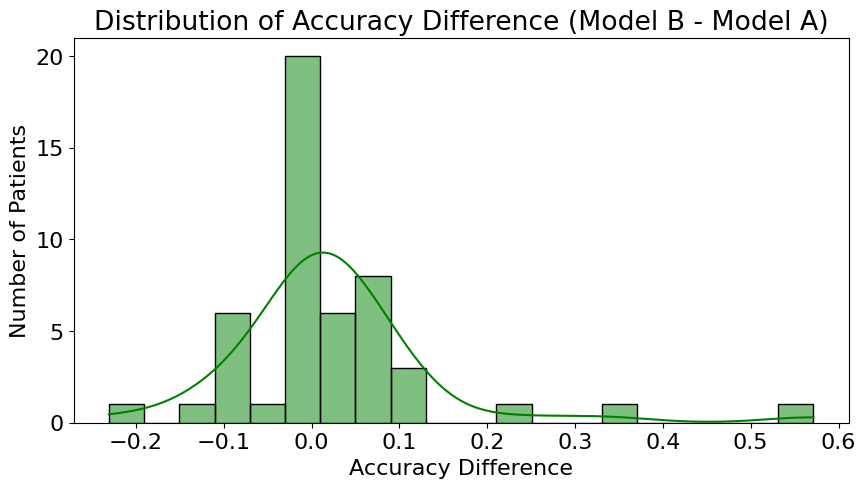

In [81]:
plt.figure(figsize=(10,5))
sns.histplot(df_compare['accuracy_diff'], bins=20, kde=True, color='green')
plt.title("Distribution of Accuracy Difference (Model B - Model A)")
plt.xlabel("Accuracy Difference")
plt.ylabel("Number of Patients")
plt.show()

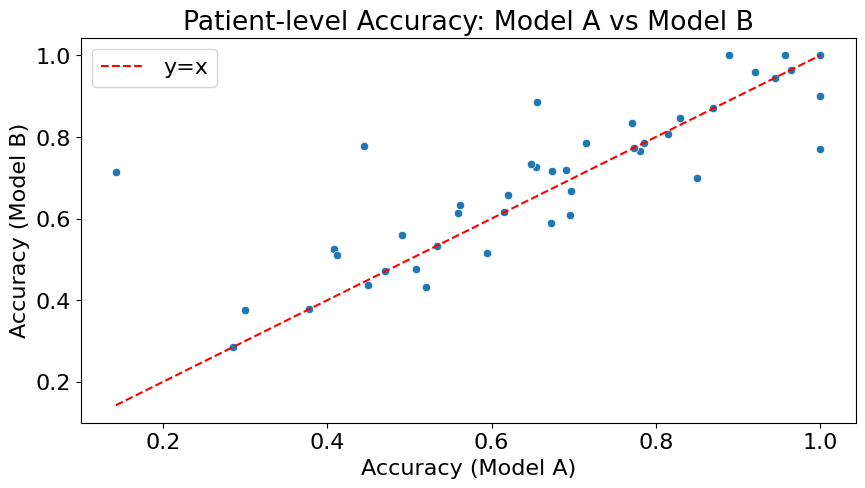

In [82]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df_compare, x='accuracy_A', y='accuracy_B')
plt.plot([df_compare['accuracy_A'].min(), df_compare['accuracy_A'].max()],
         [df_compare['accuracy_A'].min(), df_compare['accuracy_A'].max()],
         color='red', linestyle='--', label='y=x')
plt.xlabel("Accuracy (Model A)")
plt.ylabel("Accuracy (Model B)")
plt.title("Patient-level Accuracy: Model A vs Model B")
plt.legend()
plt.show()

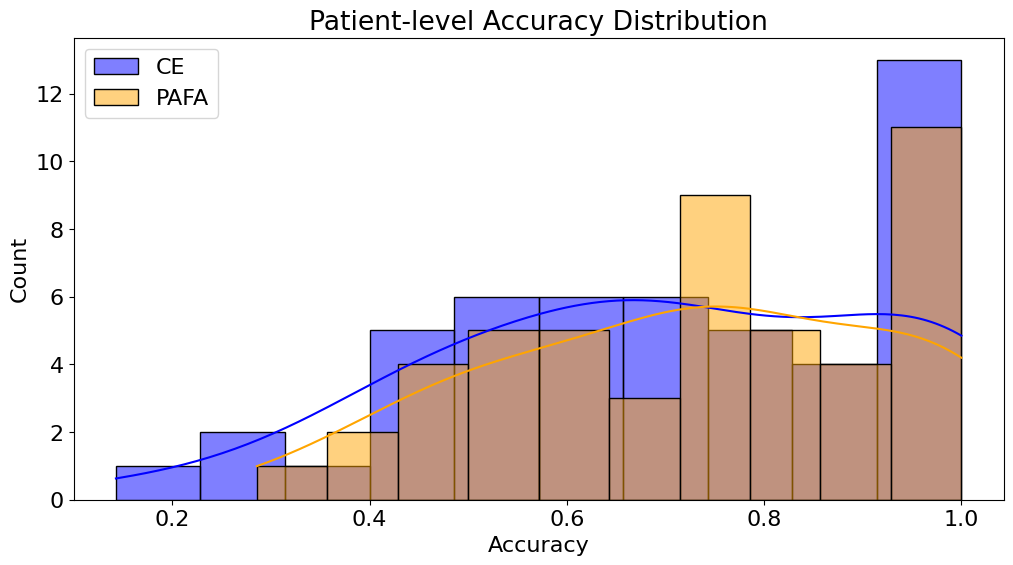

In [83]:
plt.figure(figsize=(12,6))
sns.histplot(dfA['accuracy'], bins=10, kde=True, color="blue", label="CE", alpha=0.5)
sns.histplot(dfB['accuracy'], bins=10, kde=True, color="orange", label="PAFA", alpha=0.5)
plt.title("Patient-level Accuracy Distribution")
plt.xlabel("Accuracy")
plt.ylabel("Count")
plt.legend()
plt.show()

/tmp/ipykernel_3338192/2410298578.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_all, x='Model', y='accuracy', palette='Set2')


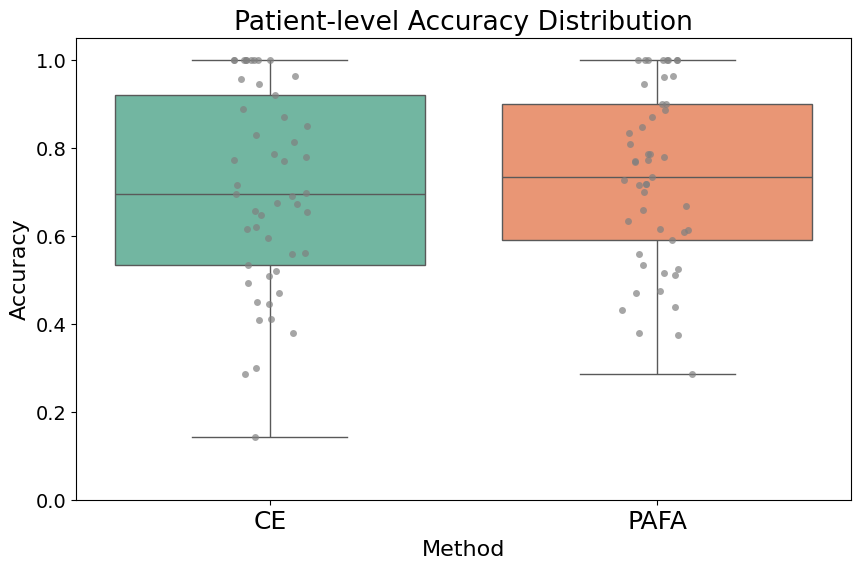

In [84]:
# 모델별 식별을 위한 컬럼 추가
dfA_plot = dfA[['patient id', 'accuracy']].copy()
dfA_plot['Model'] = 'CE'

dfB_plot = dfB[['patient id', 'accuracy']].copy()
dfB_plot['Model'] = 'PAFA'

# 두 데이터프레임 합치기
df_all = pd.concat([dfA_plot, dfB_plot], ignore_index=True)

# 폰트 크기 설정
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_all, x='Model', y='accuracy', palette='Set2')
sns.stripplot(data=df_all, x='Model', y='accuracy', color='gray', jitter=True, alpha=0.7)
plt.title('Patient-level Accuracy Distribution')
plt.xlabel('Method')
plt.ylabel('Accuracy')
plt.ylim(0, 1.05)

plt.xticks(fontsize=18)
plt.yticks(fontsize=14)

plt.show()